<a href="https://www.kaggle.com/code/syerramilli/ps3e9-xgboost-hyperopt?scriptVersionId=121609908" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

%matplotlib inline

In [2]:
curr_data_path = Path('/kaggle/input/playground-series-s3e9/')
orig_data = Path('/kaggle/input/predict-concrete-strength/')

train = pd.read_csv(curr_data_path/'train.csv')
test = pd.read_csv(curr_data_path/'test.csv')

orig = pd.read_csv(orig_data/'ConcreteStrengthData.csv')
# some of the columns have white spaces
orig.columns = orig.columns.str.replace(' ', '')

del train['id']

train

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19
...,...,...,...,...,...,...,...,...,...
5402,446.0,24.0,79.0,162.0,11.6,967.0,712.0,3,15.42
5403,350.0,0.0,0.0,203.0,0.0,974.0,775.0,180,49.20
5404,295.8,0.0,0.0,185.7,0.0,1076.2,759.3,28,39.30
5405,376.0,93.4,0.0,162.6,11.5,955.8,662.9,28,39.61


In [3]:
# there are duplicates in the training data
# average over the duplicates
predictors = train.columns[:-1].to_list()
train = train.groupby(predictors).agg('mean').reset_index()

<AxesSubplot:>

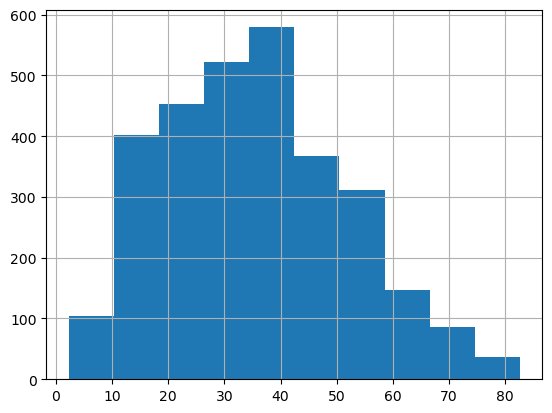

In [4]:
train['Strength'].hist()

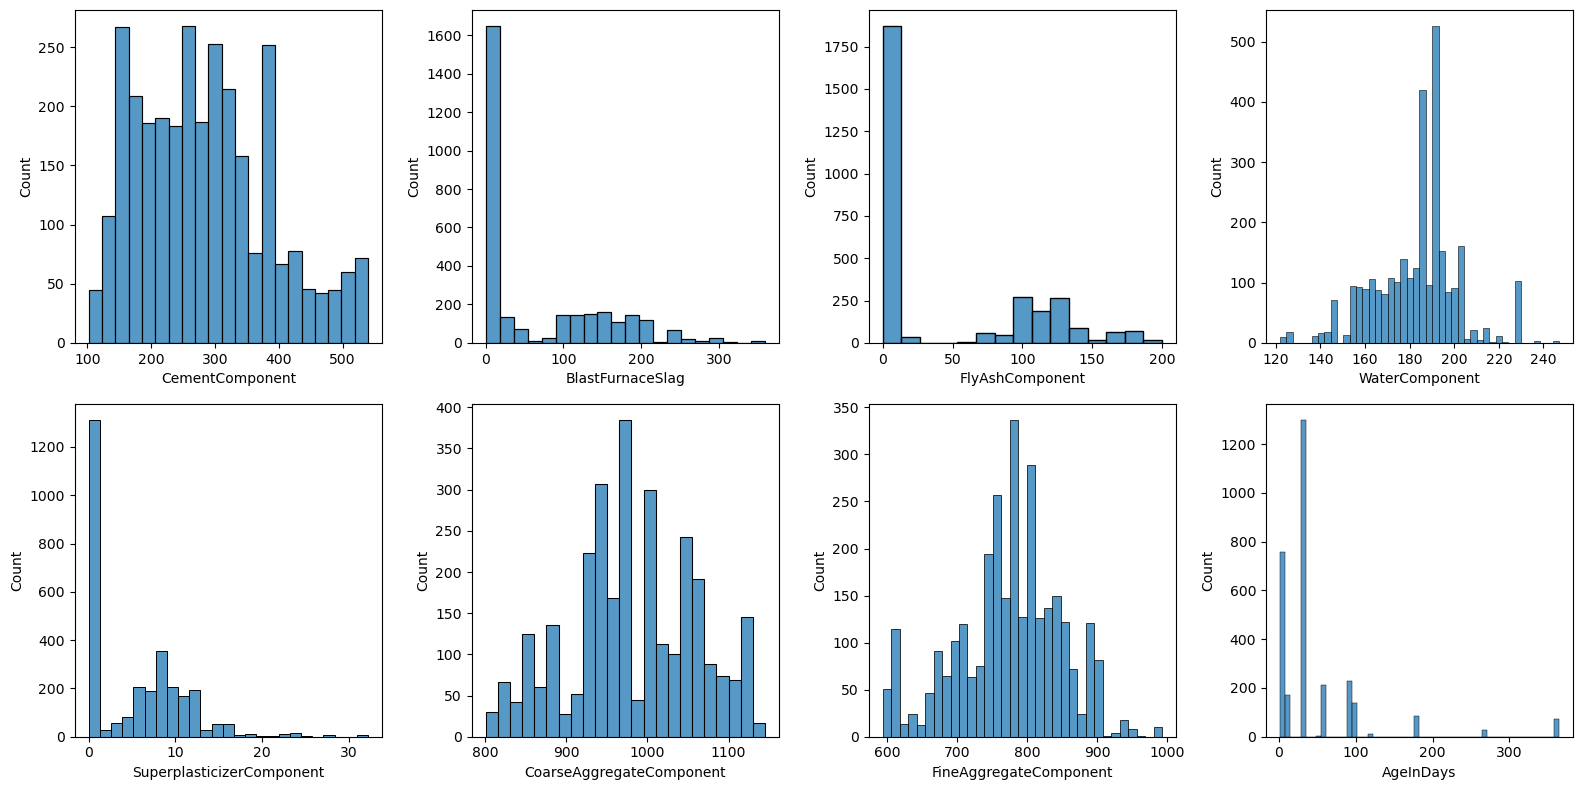

In [5]:
# histograms of predictors
n_rows = 2
n_cols = 4

fig,axs = plt.subplots(n_rows,n_cols,figsize=(4*n_cols,4*n_rows))
for i in range(n_rows):
    for j in range(n_cols):
        col_idx = n_cols*i+j
        _ = sns.histplot(data=train,x=train.columns[col_idx],ax=axs[i][j])
        
fig.tight_layout()

Some of the predictors have a rather larger number of zero values. 

In [6]:
zero_value_cols = ['BlastFurnaceSlag','FlyAshComponent','SuperplasticizerComponent']
for col in zero_value_cols:
    print('Proportion of zero_values observations for col %s: %5.3f' %(col,(train[col]==0).mean()))

Proportion of zero_values observations for col BlastFurnaceSlag: 0.537
Proportion of zero_values observations for col FlyAshComponent: 0.623
Proportion of zero_values observations for col SuperplasticizerComponent: 0.437


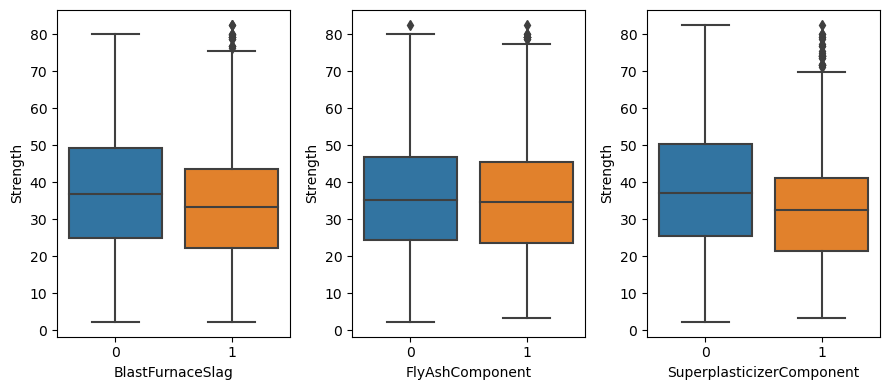

In [7]:
fig,axs = plt.subplots(1,len(zero_value_cols),figsize=(3*len(zero_value_cols),4))
for i,col in enumerate(zero_value_cols):
    indicator = 1*(train[col] == 0)
    _ = sns.boxplot(y=train['Strength'],x=indicator,ax=axs[i])

fig.tight_layout()

Only `SuperplasticizerComponent==0` seems to have some effect on the response. We might use it in a later run. 


Before we go into tuning and fitting an XGboost model, let's look at the correlations among the predictors.This might be relevant when assessing effects through partial dependence plots.

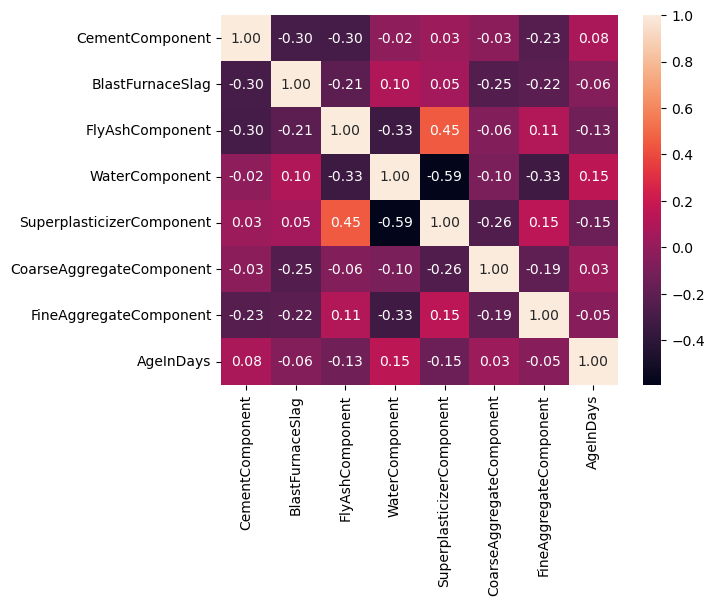

In [8]:
_ = sns.heatmap(
    train.drop('Strength',axis=1).corr(),
    annot=True,
    fmt='.2f'
)

1. It appears that`SuperplasticizerComponent` is somewhat positively correlated with `FlyAshComponent`. This could, however, be due to the large number of zero values in both predictors. 
2. `SuperplasticizerComponent` is negative correlated with `WaterComponent`. This might be something to explore. 

In [9]:
# finally, extract predictors and response.
X = train.drop('Strength',axis=1)
y = train['Strength'].values

X_orig = orig.drop('Strength',axis=1)
y_orig = orig['Strength'].values

In [10]:
pd.concat([X,X_orig],axis=0,ignore_index=True)

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays
0,102.0,0.0,0.0,192.0,0.0,879.0,942.0,3
1,102.0,153.0,0.0,192.0,0.0,887.0,942.0,3
2,102.0,153.0,0.0,192.0,0.0,887.0,942.0,7
3,102.0,153.0,0.0,192.0,0.0,887.0,942.0,28
4,102.0,153.0,0.0,192.0,0.0,887.0,942.0,90
...,...,...,...,...,...,...,...,...
4031,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28
4032,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28
4033,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28
4034,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28


In [11]:
# monotonic constraints from prior knowledge
monotone_constraints = {col:0 for col in X.columns}
monotone_constraints['CementComponent'] = 1
monotone_constraints['AgeInDays']=1

## XGboost model

### Tuning with hyperopt 

**Note:** In my previous runs, I haven't used the original data. If I were to use the original data when generating the K fold partition, the CV RMSE can't be compared with previous cases. So, we will add the original data directly to the training data within each round of K-fold CV.

In [12]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold,train_test_split
from sklearn.metrics import mean_squared_error
from joblib import Parallel,delayed

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
from hyperopt.pyll_utils import scope
from typing import Dict,Optional,Union

In [13]:
def fit_model_with_early_stopping(
    X:Union[pd.DataFrame,np.ndarray],
    y:Union[pd.Series,np.ndarray],
    config:Optional[Dict]=None,
    n_jobs:int=1,
    verbose:int=0
) -> XGBRegressor:
    
    # split data into training and validation sets
    # NOTE: this will add some randomness in the final results
    X_train,X_val, y_train, y_val = train_test_split(X,y,test_size=0.1)
    
    # ADD original data to training split
    X_train = pd.concat([X_train,X_orig],axis=0)
    y_train = np.concatenate([y_train,y_orig])
    
    model = XGBRegressor(
        n_estimators = 1500, # use a large number of trees with early stopping
        tree_method='hist',#max_depth=0,
        monotone_constraints=monotone_constraints,
        early_stopping_rounds = 10,
        n_jobs=n_jobs
    )
    
    sample_weight = np.ones(y_train.shape[0])
    if config:
        orig_sample_weight = config.pop('orig_sample_weight')
        sample_weight[-(y_orig.shape[0]):] = orig_sample_weight
        model.set_params(**config)
        
    return model.fit(X_train,y_train,sample_weight=sample_weight,eval_set=[(X_val, y_val)],verbose=verbose)
    

In [14]:
def fit_and_test_fold(config:Dict,train_index,test_index) -> float:
    X_train = X.iloc[train_index,:];X_test = X.iloc[test_index,:]
    y_train = y[train_index]; y_test = y[test_index]
    
    # fit model on training data
    model = fit_model_with_early_stopping(X_train,y_train,config)
    
    # generate predictions on test data
    y_test_pred = model.predict(X_test)
    
    # return RMSE
    return np.sqrt(mean_squared_error(y_test,y_test_pred))
    

In [15]:
# loss function
def objective(config:Optional[Dict]=None):
     
    # 8-fold cross-validation: kaggle notebooks have 4 cores available
    cv = KFold(n_splits=8,shuffle=True,random_state=1)
    
    cv_losses = Parallel(n_jobs=4,verbose=0)(
        delayed(fit_and_test_fold)(config,train_index,test_index) for train_index,test_index in cv.split(X)
    )
    
    return {'loss':np.mean(cv_losses),'status': STATUS_OK,'min_RMSE_fold':np.min(cv_losses),'max_RMSE_fold':np.max(cv_losses)}

# search space
search_space = {
    #'n_estimators': scope.int(hp.quniform('n_estimators',100,1500,1)),
    'learning_rate': hp.loguniform('learning_rate',np.log(1e-4),np.log(0.5)),
    'max_depth': scope.int(hp.quniform('max_depth',1,12,1)), # default value is 6 
    'max_leaves': scope.int(hp.qloguniform('max_leaves',np.log(2),9*np.log(2),1)), # min: 2, max: 512
    'subsample':hp.uniform('subsample',0.1,1),
    'colsample_bytree':hp.uniform('colsample_bytree',0.1,1),
    'gamma':hp.loguniform('gamma',np.log(1e-6),np.log(100)),
    'reg_alpha':hp.loguniform('reg_alpha',np.log(1e-6),np.log(100)),
    'reg_lambda':hp.loguniform('reg_lambda',np.log(1e-6),np.log(100)),
    'grow_policy':hp.choice('grow_policy',['depthwise','lossguide']), # 'depthwise' is default
    'orig_sample_weight':hp.uniform('orig_sample_weight',0,1)
}


trials = Trials()
best = fmin(
    objective,search_space,
    algo=tpe.suggest,
    max_evals = 100,
    trials=trials,
    return_argmin=False,
    rstate=np.random.default_rng(1)
)
best

100%|██████████| 100/100 [10:23<00:00,  6.23s/trial, best loss: 11.898635178492963]


{'colsample_bytree': 0.9037073003885856,
 'gamma': 0.002878614315176893,
 'grow_policy': 'depthwise',
 'learning_rate': 0.058745728481471596,
 'max_depth': 3,
 'max_leaves': 41,
 'orig_sample_weight': 0.16101586771166612,
 'reg_alpha': 0.013434124255030495,
 'reg_lambda': 0.00022974841885503954,
 'subsample': 0.5459721825492172}

In [16]:

results = pd.DataFrame([
    space_eval(search_space,row.to_dict()) for _,row in pd.DataFrame(trials.vals).iterrows()
]) 

results['RMSE'] = [tmp['loss'] for tmp in trials.results]
results['min_RMSE_fold'] = [tmp['min_RMSE_fold'] for tmp in trials.results]
results['max_RMSE_fold'] = [tmp['max_RMSE_fold'] for tmp in trials.results]
results.to_csv('cv_rmse_hyperopt.csv',index=False)
# top 10 configurations
results.sort_values('RMSE',ascending=True).head(10)

,colsample_bytree,gamma,grow_policy,learning_rate,max_depth,max_leaves,orig_sample_weight,reg_alpha,reg_lambda,subsample,RMSE,min_RMSE_fold,max_RMSE_fold
72,0.903707,0.002879,depthwise,0.058746,3,41,0.161016,0.013434,0.000230,0.545972,11.898635,11.149910,12.598639
45,0.760399,0.000345,depthwise,0.004806,5,63,0.049477,23.916384,0.037023,0.618774,11.899885,11.185612,12.640410
11,0.977916,0.006382,depthwise,0.014576,9,14,0.337826,0.030223,20.623268,0.560617,11.900412,11.171962,12.719980
54,0.688908,0.000004,depthwise,0.005900,4,15,0.240545,0.013357,0.012477,0.291524,11.912158,11.097141,12.735512
79,0.860702,0.000200,lossguide,0.126346,3,29,0.307994,0.165696,0.000048,0.556898,11.912858,11.220352,12.595522
37,0.715387,0.006936,depthwise,0.020198,10,160,0.182620,2.851105,45.522696,0.840298,11.915448,11.238705,12.678926
65,0.724922,0.000002,depthwise,0.003679,4,16,0.235307,0.016502,0.005466,0.289136,11.916058,11.109148,12.730379
66,0.684691,0.000005,depthwise,0.005294,3,14,0.348002,0.007249,0.011064,0.441736,11.916166,11.156931,12.743960
95,0.980925,0.001741,depthwise,0.045224,5,253,0.157120,15.453684,0.890171,0.571743,11.916430,11.212515,12.692305
59,0.663655,0.000001,depthwise,0.039431,5,5,0.294020,0.020777,0.000092,0.741105,11.916561,11.170263,12.732469


### Final model

In [17]:
# train model
model = fit_model_with_early_stopping(X,y,best,verbose=10)

# final number of trees
print(len(model.get_booster().get_dump()))

[0]	validation_0-rmse:36.57799
[10]	validation_0-rmse:22.92319
[20]	validation_0-rmse:16.73721
[30]	validation_0-rmse:14.27738
[40]	validation_0-rmse:13.42118
[50]	validation_0-rmse:13.16166
[60]	validation_0-rmse:13.05746
[70]	validation_0-rmse:13.05349
[80]	validation_0-rmse:13.01729
[82]	validation_0-rmse:13.01826
83


<AxesSubplot:>

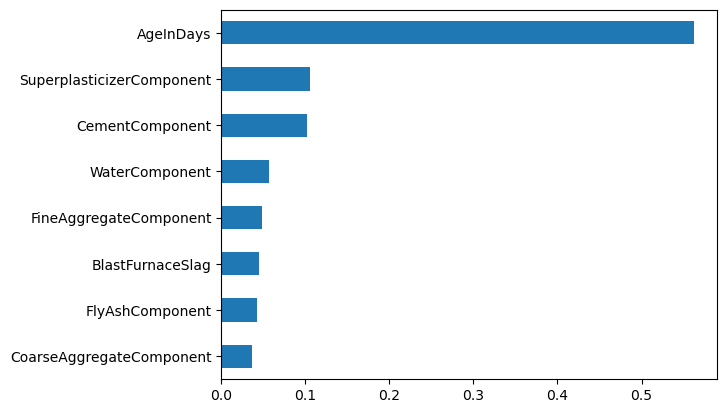

In [18]:
# gain based feature importances - not necessarily the most reliable
feat_imp = pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True)
feat_imp.plot(kind='barh')

We can also generate 1D partial dependence plots. The range of the y-values is a proxy for the extent of the effect.

**Note**: PD plots are not ideal when some of the features are correlated with each other. 

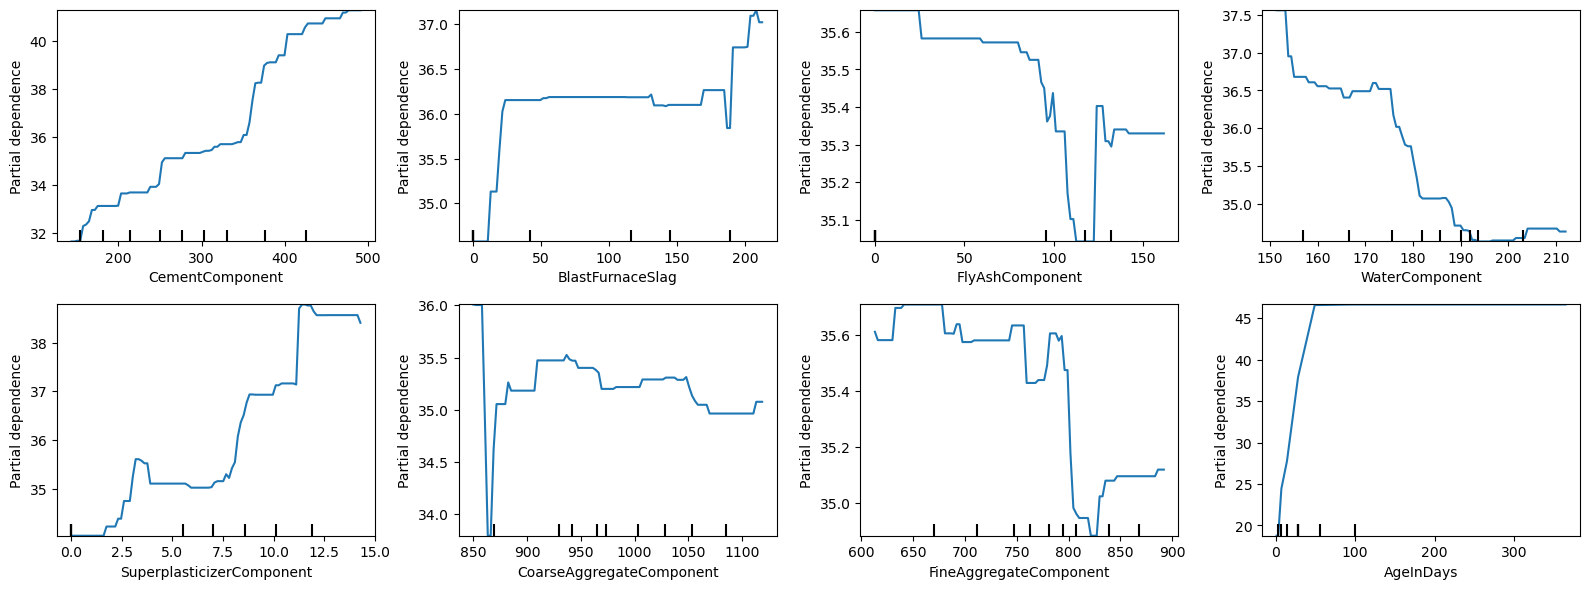

In [19]:
from sklearn.inspection import PartialDependenceDisplay

# 1-D Partial dependence plots
num_rows=2
num_cols=4
fig,axs = plt.subplots(num_rows,num_cols,figsize=(16,6))
for i in range(num_rows):
    for j in range(num_cols):
        # select correct feature
        feature = [X.columns[num_cols*i+j]]
        
        _ = PartialDependenceDisplay.from_estimator(
            model,X,features=feature,
            ax=axs[i,j]
        )

fig.tight_layout()

## Evaluate on test set

In [20]:
test_ids = test['id']
test = test.drop('id',axis=1)

submission = pd.DataFrame({'id':test_ids.values,'Strength':model.predict(test)})
submission.to_csv('submission.csv',index=False)